In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os
import sys
import main_ode

import seaborn as sns
# Set seaborn style as default
sns.set(style="whitegrid")
# Adjust font sizes globally
plt.rcParams.update({
    "font.size": 14,  # Base font size
    "axes.titlesize": 16,  # Title font size
    "axes.labelsize": 14,  # Label font size
    "xtick.labelsize": 12,  # X-axis tick label size
    "ytick.labelsize": 12,  # Y-axis tick label size
    "legend.fontsize": 12  # Legend font size
})

SLURM_CPUS_PER_TASK: 0
OMP_NUM_THREADS: 0
os.cpu_count(): 10
[JAX CONFIG] Using 10 CPU threads


In [2]:
"""
we first test the sgn_mods
"""
def covariance(Q_1, Q_2, Q_12, J_1, J_2, S):
    cov = [[Q_1, Q_12, J_1], [Q_12, Q_2, J_2], [J_1, J_2, S]]
    return np.array(cov)

def sample_fields(cov, n_samples=1000):
    mean = [0, 0, 0]
    samples = np.random.multivariate_normal(mean, cov, n_samples)
    return samples

def sample_batch(cov, n_samples=1000):
    samples = sample_fields(cov, n_samples)
    h_1 = samples[:, 0]
    h_2 = samples[:, 1]
    x = samples[:, 2]
    return h_1, h_2, x

def conditional_gaussian(mean, cov, given_index, given_value):
    """
    Compute conditional Gaussian distribution:
    X ~ N(mean, cov)
    Condition on X[given_index] = given_value
    
    Returns (cond_mean, cond_cov)
    """
    idx = np.arange(len(mean))
    idx2 = np.delete(idx, given_index)

    # Partition the mean and covariance
    
    Sigma11 = cov[given_index, given_index]
    Sigma12 = cov[given_index, idx2]
    Sigma21 = cov[idx2, given_index]
    Sigma22 = cov[np.ix_(idx2, idx2)]

    # Conditional mean and covariance
    cond_cov = Sigma22 - np.outer(Sigma21, Sigma12) / Sigma11
    
    return cond_cov

In [3]:
from numpy import random
"""
create teacher and students for actual J Q values
"""
def perceptron(dim, Covariance):
    teacher = random.multivariate_normal(mean=np.zeros(Covariance.shape[0]), cov=Covariance)
    teacher = teacher / np.linalg.norm(teacher) * np.sqrt(dim)
    return teacher

def population_covariance(D, delta, index):
    covariance_matrix = np.zeros((D, D))
    #index = int(jnp.round((1-rho) * D))
    covariance_matrix[:index, :index] = np.eye(index)
    covariance_matrix[index:, index:] = np.eye(D - index) * delta
    return covariance_matrix

def order_params_ode(students_1, students_2, teacher, D):
    J_1 = np.einsum('D, D -> ', students_1, teacher) / D
    J_2 = np.einsum('D, D -> ', students_2, teacher) / D
    Q_1 = np.einsum('D, D -> ', students_1, students_1) / D
    Q_2 = np.einsum('D, D -> ', students_2, students_2) / D
    Q_12 = np.einsum('D, D -> ', students_1, students_2) / D
    S = np.einsum('D, D -> ', teacher, teacher) / D
    return J_1, J_2, Q_1, Q_2, Q_12, S

lr = 1
T = 4
D = 1000
n = 400000

index = 1

Covariance_t = population_covariance(D, 0.0, index)
Covariance_1 = population_covariance(D, 0.0, index)
Covariance_2 = population_covariance(D, 0.0, index)


teacher = perceptron(D, Covariance_t)
student_1 = perceptron(D, Covariance_1)
#student_2 = perceptron(D, Covariance_2)
student_2 = student_1 + np.random.normal(0, 1, D) * 0.001

J_1, J_2, Q_1, Q_2, Q_12, S = order_params_ode(student_1, student_2, teacher, D)


In [61]:
T = 5

In [4]:
print("J_1, J_2, Q_1, Q_2, Q_12, S")
print(J_1, J_2, Q_1, Q_2, Q_12, S)

J_1, J_2, Q_1, Q_2, Q_12, S
-0.9999999999920823 -1.0000257136126314 0.9999999999999998 1.0000524213486914 1.0000257135158424 0.9999999999999993


In [5]:
"""Sample observations"""
def sample_observations(T, D, n):
    X_s = random.multivariate_normal(mean=np.zeros(D), cov=np.eye(D), size=(n, T))
    return X_s

def Decisions(perceptron, X_s):
    Y_s = np.sign(np.einsum('D, n T D -> n T', perceptron, X_s))
    return Y_s

def Individual_ALL(y_s, y_t):
    reward = np.all(y_s == y_t, axis=1).astype(np.float32)
    return reward

def Collaborative_ALL(y_1, y_2, y_t):
    reward = (np.all(y_1 == y_2, axis=1) * np.all(y_1 != y_t, axis=1)).astype(np.float32)
    return reward

def Reward(r_1, r_2, r_12, tau_1, tau_2, Individual_1, Individual_2, Collaborative):
    collaborative_reward = r_12 * Collaborative
    reward_1 = r_1 * Individual_1
    reward_2 = r_2 * Individual_2

    R_1 = reward_1 + tau_2 * reward_2 + collaborative_reward
    R_2 = reward_2 + tau_1 * reward_1 + collaborative_reward
    return R_1, R_2

def student_update(y_s, x_s, R, lr, D, T):
    update = lr / (T * np.sqrt(D)) * np.einsum('n T, n T D -> n D',(y_s * R[:, np.newaxis]), x_s)
    return update

In [6]:
X_s = sample_observations(T, D, n)
y_1 = Decisions(student_1, X_s)
y_2 = Decisions(student_2, X_s)
y_t = Decisions(teacher, X_s)

In [7]:
individual_1 = Individual_ALL(y_1, y_t)
individual_2 = Individual_ALL(y_2, y_t)
collaborative = Collaborative_ALL(y_1, y_2, y_t)

In [8]:
r_1 = 0.0
r_2 = 0.0
r_12 = 1.0
tau_1 = 0.0
tau_2 = 0.0

In [9]:
reward_1, reward_2 = Reward(r_1, r_2, r_12, tau_1, tau_2, individual_1, individual_2, collaborative)
delta_1 = student_update(y_1, X_s, reward_1, lr, D, T)
delta_2 = student_update(y_2, X_s, reward_2, lr, D, T)

In [22]:
"""Computing expectations"""
def ModX(Q):
    return np.sqrt(2 * Q / np.pi)

def SgnX_Y(Q_x, J_xy):
    return np.sqrt(2 / np.pi) * J_xy / np.sqrt(Q_x)

def SgnXY(Q_x, Q_y, J_xy):
    return 2 / np.pi * np.arcsin(J_xy / np.sqrt(Q_x * Q_y))

def RhoXY_Z(Q_x, Q_y, Q_z, J_xz, J_yz, J_xy):
    return (J_xy * Q_z - J_xz * J_yz) / np.sqrt((Q_x * Q_z - J_xz**2) * (Q_y * Q_z - J_yz**2))

def HeaviLambdaNu(J, Q):
    return 1 - 1 / np.pi * np.arccos(J / np.sqrt(Q))
    
def Heavi12_heavi12Nu(J_1, J_2, Q_1, Q_2, Q_12, S):
    prob = 1/4 + 1/(2 * np.pi) * (np.arcsin(Q_12 / np.sqrt(Q_1*Q_2)) + np.arcsin(J_1/np.sqrt(Q_1*S)) + np.arcsin(J_2/np.sqrt(Q_2*S)))
    return prob

def Heavi12_negheavi12Nu(J_1, J_2, Q_1, Q_2, Q_12, S):
    prob = 1/(2 * np.pi) * (-np.arccos(Q_12 / np.sqrt(Q_1*Q_2)) + np.arccos(J_1/np.sqrt(Q_1*S)) + np.arccos(J_2/np.sqrt(Q_2*S)))
    return prob

def Sgn2Nu_mod1(Q_1, Q_2, S, J_1, J_2, Q_12):
    return (2 * np.sqrt(2) / (np.pi * np.sqrt(np.pi)) * 
            (np.sqrt(Q_1) * np.arcsin(RhoXY_Z(Q_2, S, Q_1, Q_12, J_1, J_2))
              + Q_12 / np.sqrt(Q_2) * np.arcsin(RhoXY_Z(Q_1, S, Q_2, Q_12, J_2, J_1))
                + J_1 / np.sqrt(S) * np.arcsin(RhoXY_Z(Q_1, Q_2, S, J_1, J_2, Q_12))))

def Sgn1Nu_mod2(Q_1, Q_2, S, J_1, J_2, Q_12):
    return (2 * np.sqrt(2) / (np.pi * np.sqrt(np.pi)) * 
            (np.sqrt(Q_2) * np.arcsin(RhoXY_Z(Q_1, S, Q_2, Q_12, J_2, J_1))
              + Q_12 / np.sqrt(Q_1) * np.arcsin(RhoXY_Z(Q_2, S, Q_1, Q_12, J_1, J_2))
                + J_2 / np.sqrt(S) * np.arcsin(RhoXY_Z(Q_1, Q_2, S, J_1, J_2, Q_12))))

def Sgn12_modNu(Q_1, Q_2, S, J_1, J_2, Q_12):
    return (2 * np.sqrt(2) / (np.pi * np.sqrt(np.pi)) * 
            (np.sqrt(S) * np.arcsin(RhoXY_Z(Q_1, Q_2, S, J_1, J_2, Q_12))
              + J_1 / np.sqrt(Q_1) * np.arcsin(RhoXY_Z(Q_2, S, Q_1, Q_12, J_1, J_2))
                + J_2 / np.sqrt(Q_2) * np.arcsin(RhoXY_Z(Q_1, S, Q_2, Q_12, J_2, J_1))))

def Compute_expectations(Q_1, Q_2, Q_12, J_1, J_2, S):
    P_1 = HeaviLambdaNu(J_1, Q_1)
    P_2 = HeaviLambdaNu(J_2, Q_2)
    P_12 = Heavi12_heavi12Nu(J_1, J_2, Q_1, Q_2, Q_12, S)
    P_12_collab = Heavi12_negheavi12Nu(J_1, J_2, Q_1, Q_2, Q_12, S)

    sgn12_modNu = Sgn12_modNu(Q_1, Q_2, S, J_1, J_2, Q_12)
    sgn1Nu_mod2 = Sgn1Nu_mod2(Q_1, Q_2, S, J_1, J_2, Q_12)
    sgn2Nu_mod1 = Sgn2Nu_mod1(Q_1, Q_2, S, J_1, J_2, Q_12)

    sgn1_Nu = SgnX_Y(Q_1, J_1)
    sgn2_Nu = SgnX_Y(Q_2, J_2)
    sgnNu_1 = SgnX_Y(S, J_1)
    sgnNu_2 = SgnX_Y(S, J_2)
    sgn1_2 = SgnX_Y(Q_1, Q_12)
    sgn2_1 = SgnX_Y(Q_2, Q_12)

    sgn12 = SgnXY(Q_1, Q_2, Q_12)
    sgnNu1 = SgnXY(Q_1, S, J_1)
    sgnNu2 = SgnXY(Q_2, S, J_2)

    mod1 = ModX(Q_1)
    mod2 = ModX(Q_2)
    modNu = ModX(S)

    return P_1, P_2, P_12, P_12_collab, \
        sgn12_modNu, sgn1Nu_mod2, sgn2Nu_mod1, \
            sgn1_Nu, sgn2_Nu, sgnNu_1, sgnNu_2, sgn1_2, sgn2_1, \
                sgn12, sgnNu1, sgnNu2, \
                    mod1, mod2, modNu

In [23]:
def dJ_i(T, eta, r_i, r_j, r_12, tau_j, sgni_Nu, sgnj_Nu, sgn12_modNu, modNu, P_i, P_j, P_12_collab):
    dj = eta * (r_i / 2 * P_i**(T - 1) * (sgni_Nu + modNu) + tau_j * r_j / 2 * P_j**(T - 1) * (sgn12_modNu + sgni_Nu)
                  + r_12 / 4 * P_12_collab**(T - 1) * (sgni_Nu + sgnj_Nu - sgn12_modNu - modNu))
    return dj

def dQ_i(T, eta, r_i, r_j, r_12, tau_j, modi, sgnNu_i, sgnjNu_modi, sgnj_i, 
         P_i, P_j, P_12, P_12_collab):
    dq = (eta * (r_i * P_i**(T - 1) * (modi + sgnNu_i) + tau_j * r_j * P_j**(T - 1) * (modi + sgnjNu_modi) + 
                 r_12 / 2 * P_12_collab**(T - 1) * (modi + sgnj_i - sgnjNu_modi - sgnNu_i)) + 
                 eta**2 / T * (r_i**2 * P_i**T + tau_j * r_j**2 * P_j**T + 
                               r_12**2 * P_12_collab**T + r_i * r_j * tau_j * P_12**T))
    return dq

def dQ_ij(T, eta, r_1, r_2, r_12, tau_1, tau_2, mod1, mod2, sgn1_2, sgn2_1, sgnNu_1, 
          sgnNu_2, sgn12, sgnNu1, sgnNu2, sgn1Nu_mod2, sgn2Nu_mod1, P_1, P_2, P_12, P_12_collab):
    dq_ij = (eta / 2 * (r_1 * (sgn1_2 + sgnNu_2 + tau_1 * (sgn2_1 + sgn2Nu_mod1)) * P_1**(T - 1) + r_2 * (sgn2_1 + sgnNu_1 + tau_2 * (sgn1_2 + sgn1Nu_mod2)) * P_2**(T - 1) + 
                    r_12 / 4 * (mod2 + sgn1_2 - sgn1Nu_mod2 - sgnNu_2 + mod1 + sgn2_1 - sgn2Nu_mod1 - sgnNu_1) * P_12_collab**(T - 1)) + 
                    eta**2 / T * ((1 + tau_1 * tau_2) * r_1 * r_2 / 4 * (1 + sgn12 + sgnNu1 + sgnNu2) * P_12**(T - 1) + 
                                  r_12**2 / 4 * (1 + sgn12 - sgnNu1 - sgnNu2) * P_12_collab**(T - 1) + 
                                  tau_1 * r_1**2 / 2 * (sgn12 + sgnNu2) * P_1**(T - 1) + tau_2 * r_2**2 / 2 * (sgn12 + sgnNu1) * P_2**(T - 1)))
    return dq_ij

In [10]:
"""
calculated emperical changes in J_s and Q_s
"""
J_1_emp = np.einsum('n D, D -> n', delta_1, teacher) / D
J_2_emp = np.einsum('n D, D -> n', delta_2, teacher) / D
Q_1_emp = np.einsum('n D, n D -> n', delta_1, delta_1) / D + 2 * np.einsum('D, n D -> n', student_1, delta_1) / D
Q_2_emp = np.einsum('n D, n D -> n', delta_2, delta_2) / D + 2 * np.einsum('D, n D -> n', student_2, delta_2) / D
Q_12_emp = np.einsum('n D, n D -> n', delta_1, delta_2) / D + np.einsum('D, n D -> n', student_1, delta_2) / D + np.einsum('D, n D -> n', student_2, delta_1) / D

In [11]:
J_1_ode = np.einsum('D, D -> ', student_1, teacher) / D
J_2_ode = np.einsum('D, D -> ', student_2, teacher) / D
Q_1_ode = np.einsum('D, D -> ', student_1, student_1) / D
Q_2_ode = np.einsum('D, D -> ', student_2, student_2) / D
Q_12_ode = np.einsum('D, D -> ', student_1, student_2) / D

P_1, P_2, P_12, P_12_collab, \
        sgn12_modNu, sgn1Nu_mod2, sgn2Nu_mod1, \
        sgn1_Nu, sgn2_Nu, sgnNu_1, sgnNu_2, sgn1_2, sgn2_1, \
        sgn12, sgnNu1, sgnNu2, \
        mod1, mod2, modNu = Compute_expectations(Q_1, Q_2, Q_12, J_1, J_2, S)



NameError: name 'Compute_expectations' is not defined

In [ ]:
dt = 1/D

dJ_1 = dJ_i(T, lr, r_1, r_2, r_12, tau_2, sgn1_Nu, sgn2_Nu, sgn12_modNu, modNu, P_1, P_2, P_12_collab) * dt
dJ_2 = dJ_i(T, lr, r_2, r_1, r_12, tau_1, sgn2_Nu, sgn1_Nu, sgn12_modNu, modNu, P_2, P_1, P_12_collab) * dt
dQ_1 = dQ_i(T, lr, r_1, r_2, r_12, tau_2, mod1, sgnNu_1, sgn2Nu_mod1, sgn2_1, P_1, P_2, P_12, P_12_collab) * dt
dQ_2 = dQ_i(T, lr, r_2, r_1, r_12, tau_1, mod2, sgnNu_2, sgn1Nu_mod2, sgn1_2, P_2, P_1, P_12, P_12_collab) * dt
dQ_12 = dQ_ij(T, lr, r_1, r_2, r_12, tau_1, tau_2, mod1, mod2, sgn1_2, sgn2_1, sgnNu_1, sgnNu_2, sgn12, sgnNu1, 
                sgnNu2, sgn1Nu_mod2, sgn2Nu_mod1, P_1, P_2, P_12, P_12_collab) * dt

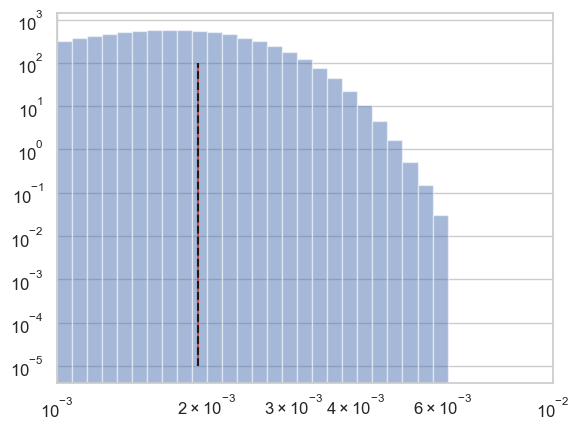

In [ ]:
bins = np.logspace(-4, -1, 100)
plt.hist(Q_1_emp, bins=bins, alpha=0.5, label='Q_1_emp - dQ_1', density=True, cumulative=False);

plt.vlines(dQ_1, ymin=1e-5, ymax=1e2, colors='r', label='dQ_1')
plt.vlines(Q_1_emp.mean(), ymin=1e-5, ymax=1e2, colors='k', label='dQ_1', linestyles='dashed')
# plt.hist(dQ_1, bins=bins, alpha=0.5, label='Q_1_emp - dQ_1', density=True, cumulative=False);
plt.xlim(1e-3,1e-2)
plt.xscale('log')
plt.yscale('log')

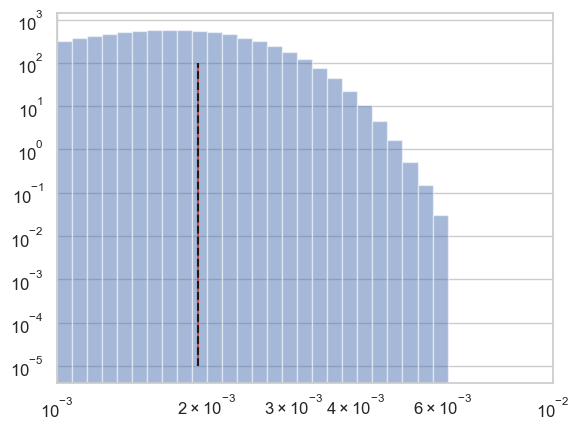

Min:0.0003429850904188336 Max:0.005918902372988827


In [ ]:
bins = np.logspace(-4, -1, 100)
plt.hist(Q_12_emp, bins=bins, alpha=0.5, label='Q_12_emp ', density=True, cumulative=False);
plt.vlines(1.705*dQ_12, ymin=1e-5, ymax=1e2, colors='r', label='dQ_12')
plt.vlines(Q_12_emp.mean(), ymin=1e-5, ymax=1e2, colors='k', label='dQ_12', linestyles='dashed')
# plt.hist(dQ_1, bins=bins, alpha=0.5, label='Q_1_emp - dQ_1', density=True, cumulative=False);
plt.xlim(1e-3,1e-2)
plt.xscale('log')
plt.yscale('log')
plt.show()

vals= [val.item() for val in sorted(Q_12_emp) if val.item()>0];
# plt.semilogx(vals, np.arange(len(vals)), marker='.', linestyle='none');
# plt.ylim(340000,400000)
print(f"Min:{min(vals)}", f"Max:{max(vals)}")

In [93]:
1/1000**.5

0.03162277660168379

Min:0.0004288647033115827 Max:0.00522786823117311


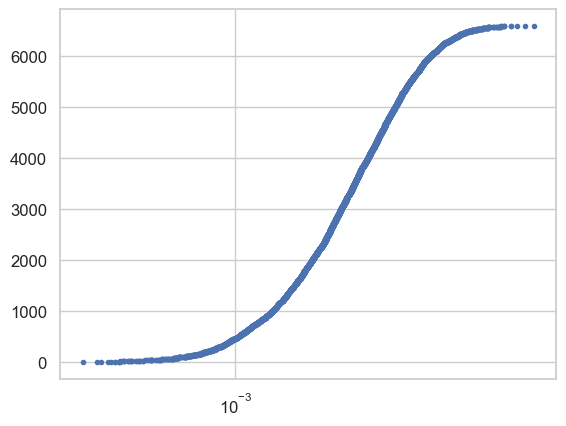

In [78]:
vals= [val.item() for val in sorted(Q_1_emp) if val.item()>0];
plt.semilogx(vals, np.arange(len(vals)), marker='.', linestyle='none');
# plt.ylim(340000,400000)
print(f"Min:{min(vals)}", f"Max:{max(vals)}")

In [65]:
min([val.item() for val in sorted(Q_1_emp) if val.item()>0])

0.000380086813216017

(-0.0005, 0.0005)

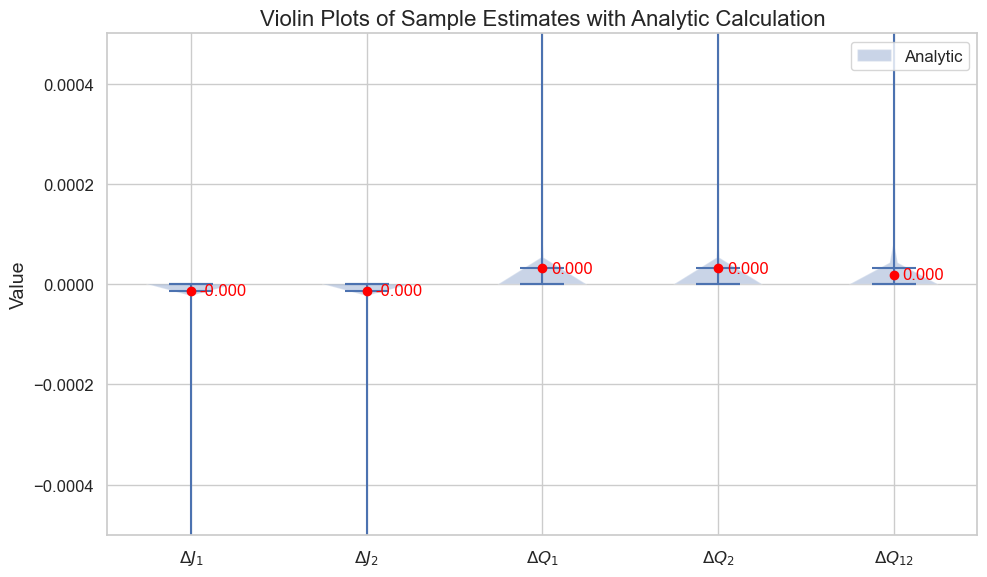

In [76]:
fig, ax = plt.subplots(figsize=(10, 6))

# Data for violin plots
data = [
    J_1_emp,
    J_2_emp,
    Q_1_emp,
    Q_2_emp,
    Q_12_emp

]
labels = [
    r"${\Delta}J_1$",
    r"${\Delta}J_2$",
    r"${\Delta}Q_1$",
    r"${\Delta}Q_2$",
    r"${\Delta}Q_{12}$"
]
analytics = [
    dJ_1,
    dJ_2,
    dQ_1,
    dQ_2,
    dQ_12
]

# Create violin plots
parts = ax.violinplot(data, showmeans=True, showmedians=True, showextrema=True)
# parts = ax.hist(data) #showmeans=True, showmedians=True, showextrema=True)

# Set x-ticks and labels
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xticklabels(labels)

# Annotate analytic values
for i, analytic in enumerate(analytics):
    ax.scatter(i+1, analytic, color='red', zorder=3, label='Analytic' if i == 0 else "")
    ax.text(i+1+0.05, analytic, f"{analytic:.3f}", color='red', va='center', fontsize=12)

ax.set_ylabel("Value")
ax.set_title("Violin Plots of Sample Estimates with Analytic Calculation")
ax.legend(["Analytic"], loc="upper right")
plt.tight_layout()
# Show empirical means as blue dashed lines and annotate them
"""for i, arr in enumerate(data):
    mean_val = np.mean(arr)
    ax.axhline(mean_val, color='blue', linestyle='--', xmin=(i)/5, xmax=(i+1)/5)"""
    #ax.text(i+1+0.05, mean_val, f"mean={mean_val:.3e}", color='blue', va='center', fontsize=12)

# Show mean value in x labels
"""xticklabels_with_max = [
    f"{label}\nmax={np.max(arr):.3e}" for label, arr in zip(labels, data)
]
ax.set_xticklabels(xticklabels_with_max)"""

ax.set_ylim(bottom=-0.0005, top=0.0005)  # Set y-axis lower limit to 0

In [41]:
#sample batch of vectors:
Q_1, Q_2, Q_12, J_1, J_2, S = 0.8, 0.9, -0.6, -0.7, 0.5, 1
lambd, sigma, nu = sample_batch(covariance(Q_1, Q_2, Q_12, J_1, J_2, S), n_samples=5000000)

#sample conditioned on lamd = 0


In [52]:
cond_cov_lambd = conditional_gaussian([0, 0, 0], covariance(Q_1, Q_2, Q_12, J_1, J_2, S), 
                                                 given_index=0, given_value=0)

cond_cov_sigma = conditional_gaussian([0, 0, 0], covariance(Q_1, Q_2, Q_12, J_1, J_2, S), 
                                                 given_index=1, given_value=0)

cond_cov_nu = conditional_gaussian([0, 0, 0], covariance(Q_1, Q_2, Q_12, J_1, J_2, S), 
                                                 given_index=2, given_value=0)


sigma_cond_lambd, nu_cond_lambd = np.random.multivariate_normal([0, 0], cond_cov_lambd, 500000).T
lambd_cond_sigma, nu_cond_sigma = np.random.multivariate_normal([0, 0], cond_cov_sigma, 500000).T
lambd_cond_nu, sigma_cond_nu = np.random.multivariate_normal([0, 0], cond_cov_nu, 500000).T

In [67]:
def Rho1nu_2(Q_1, Q_2, S, J_1, J_2, Q_12):
    return (J_1 * Q_2 - J_2 * Q_12) / np.sqrt((Q_1 * Q_2- Q_12**2) * (Q_2 * S - J_2**2))

def Rho2nu_1(Q_1, Q_2, S, J_1, J_2, Q_12):
    return (J_2 * Q_1 - J_1 * Q_12) / np.sqrt((Q_1 * Q_2- Q_12**2) * (Q_1 * S - J_1**2))

def Rho12_nu(Q_1, Q_2, S, J_1, J_2, Q_12):
    return (Q_12 * S - J_1 * J_2) / np.sqrt((Q_1 * S - J_1**2) * (Q_2 * S - J_2**2))

def RhoXY_Z(Q_x, Q_y, Q_z, J_xz, J_yz, J_xy):
    return (J_xy * Q_z - J_xz * J_yz) / np.sqrt((Q_x * Q_z - J_xz**2) * (Q_y * Q_z - J_yz**2))


def Sgn2Nu_mod1(Q_1, Q_2, S, J_1, J_2, Q_12):
    return (2 * np.sqrt(2) / (np.pi * np.sqrt(np.pi)) * 
            (np.sqrt(Q_1) * np.arcsin(RhoXY_Z(Q_2, S, Q_1, Q_12, J_1, J_2))
              + Q_12 / np.sqrt(Q_2) * np.arcsin(RhoXY_Z(Q_1, S, Q_2, Q_12, J_2, J_1))
                + J_1 / np.sqrt(S) * np.arcsin(RhoXY_Z(Q_1, Q_2, S, J_1, J_2, Q_12))))

def Sgn1Nu_mod2(Q_1, Q_2, S, J_1, J_2, Q_12):
    return (2 * np.sqrt(2) / (np.pi * np.sqrt(np.pi)) * 
            (np.sqrt(Q_2) * np.arcsin(RhoXY_Z(Q_1, S, Q_2, Q_12, J_2, J_1))
              + Q_12 / np.sqrt(Q_1) * np.arcsin(RhoXY_Z(Q_2, S, Q_1, Q_12, J_1, J_2))
                + J_2 / np.sqrt(S) * np.arcsin(RhoXY_Z(Q_1, Q_2, S, J_1, J_2, Q_12))))

def Sgn12_modNu(Q_1, Q_2, S, J_1, J_2, Q_12):
    return (2 * np.sqrt(2) / (np.pi * np.sqrt(np.pi)) * 
            (np.sqrt(S) * np.arcsin(RhoXY_Z(Q_1, Q_2, S, J_1, J_2, Q_12))
              + J_1 / np.sqrt(Q_1) * np.arcsin(RhoXY_Z(Q_2, S, Q_1, Q_12, J_1, J_2))
                + J_2 / np.sqrt(Q_2) * np.arcsin(RhoXY_Z(Q_1, S, Q_2, Q_12, J_2, J_1))))


sgn12_modNu = Sgn12_modNu(Q_1, Q_2, S, J_1, J_2, Q_12)
sgn1Nu_mod2 = Sgn1Nu_mod2(Q_1, Q_2, S, J_1, J_2, Q_12)
sgn2Nu_mod1 = Sgn2Nu_mod1(Q_1, Q_2, S, J_1, J_2, Q_12)

sgn12_modNu_samples = np.sign(lambd * sigma) * np.abs(nu)
sgn1Nu_mod2_samples = np.sign(lambd * nu) * np.abs(sigma)
sgn2Nu_mod1_samples = np.sign(sigma * nu) * np.abs(lambd)

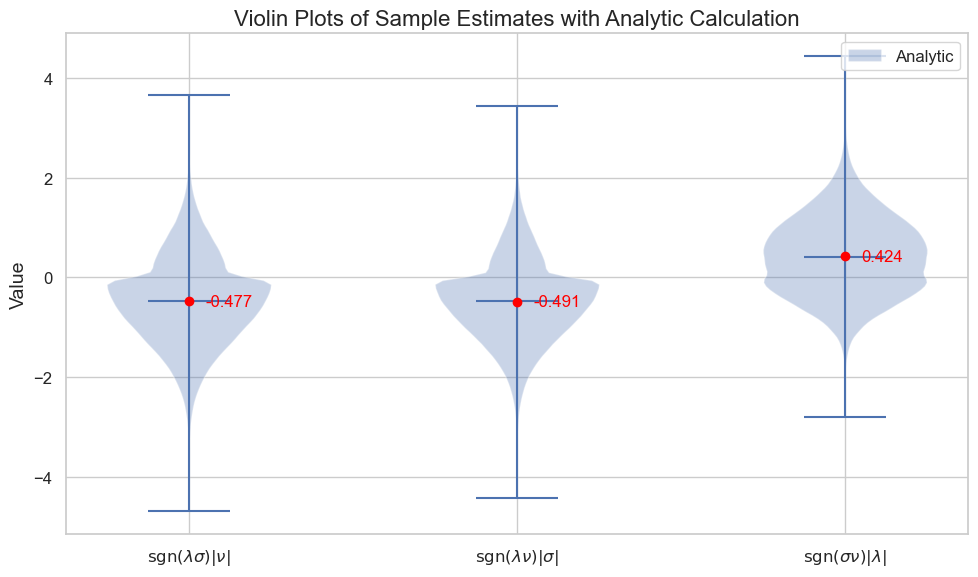

In [68]:
fig, ax = plt.subplots(figsize=(10, 6))

# Data for violin plots
data = [
    sgn12_modNu_samples,
    sgn1Nu_mod2_samples,
    sgn2Nu_mod1_samples
]
labels = [
    r"$\mathrm{sgn}(\lambda\sigma)|\nu|$",
    r"$\mathrm{sgn}(\lambda\nu)|\sigma|$",
    r"$\mathrm{sgn}(\sigma\nu)|\lambda|$"
]
analytics = [
    float(sgn12_modNu),
    float(sgn1Nu_mod2),
    float(sgn2Nu_mod1)
]

# Create violin plots
parts = ax.violinplot(data, showmeans=False, showmedians=True, showextrema=True)

# Set x-ticks and labels
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(labels)

# Annotate analytic values
for i, analytic in enumerate(analytics):
    ax.scatter(i+1, analytic, color='red', zorder=3, label='Analytic' if i == 0 else "")
    ax.text(i+1+0.05, analytic, f"{analytic:.3f}", color='red', va='center', fontsize=12)

ax.set_ylabel("Value")
ax.set_title("Violin Plots of Sample Estimates with Analytic Calculation")
ax.legend(["Analytic"], loc="upper right")
plt.tight_layout()
plt.show()

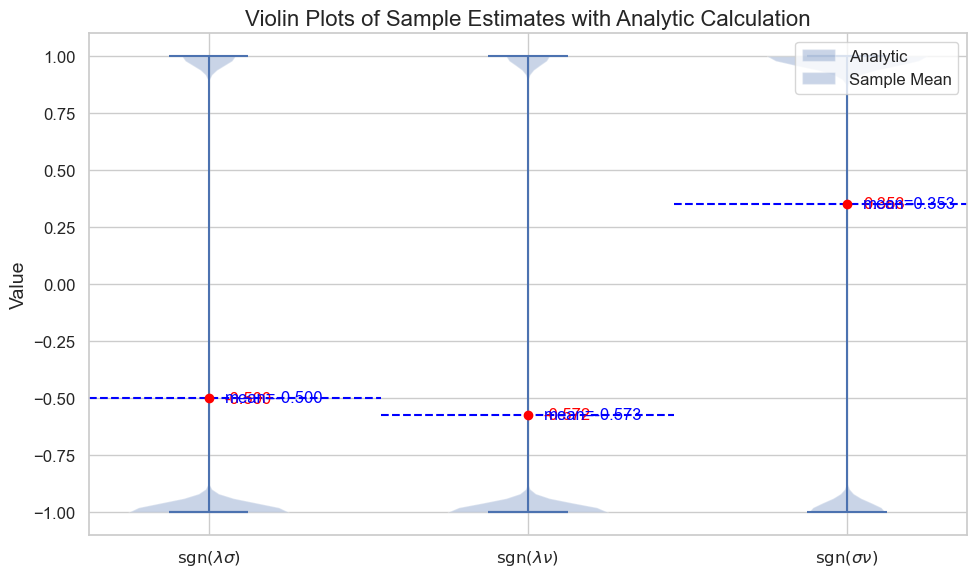

In [42]:
"""
we do the same thing for the next set of expectations
"""
sgn12 = main_ode.SgnXY(Q_1, Q_2, Q_12)
sgnNu1 = main_ode.SgnXY(Q_1, S, J_1)
sgnNu2 = main_ode.SgnXY(Q_2, S, J_2)

sgn12_samples = np.sign(lambd * sigma)
sgnNu1_samples = np.sign(lambd * nu)
sgnNu2_samples = np.sign(sigma * nu)

fig, ax = plt.subplots(figsize=(10, 6))

# Data for violin plots
data = [
    sgn12_samples,
    sgnNu1_samples,
    sgnNu2_samples
]
labels = [
    r"$\mathrm{sgn}(\lambda\sigma)$",
    r"$\mathrm{sgn}(\lambda\nu)$",
    r"$\mathrm{sgn}(\sigma\nu)$"
]
analytics = [
    float(sgn12),
    float(sgnNu1),
    float(sgnNu2)
]

# Create violin plots
parts = ax.violinplot(data, showmeans=False, showmedians=True, showextrema=True)

# Set x-ticks and labels
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(labels)

# Annotate analytic values
for i, analytic in enumerate(analytics):
    ax.scatter(i+1, analytic, color='red', zorder=3, label='Analytic' if i == 0 else "")
    ax.text(i+1+0.05, analytic, f"{analytic:.3f}", color='red', va='center', fontsize=12)
    # Show mean of samples
    sample_mean = np.mean(data[i])
    ax.axhline(sample_mean, color='blue', linestyle='--', xmin=(i)/3, xmax=(i+1)/3, label='Sample Mean' if i == 0 else "")
    ax.text(i+1+0.05, sample_mean, f"mean={sample_mean:.3f}", color='blue', va='center', fontsize=12)

ax.set_ylabel("Value")
ax.set_title("Violin Plots of Sample Estimates with Analytic Calculation")
ax.legend(["Analytic", "Sample Mean"], loc="upper right")
plt.tight_layout()
plt.show()

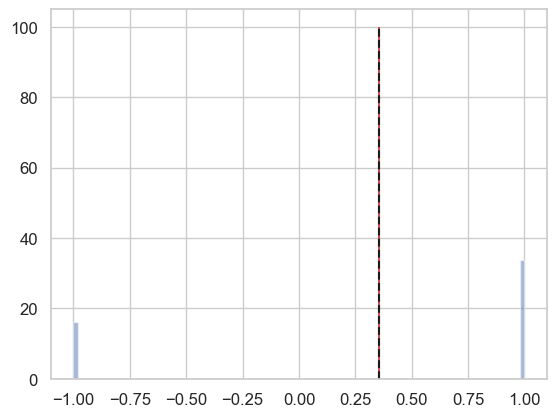

In [54]:
bins = np.logspace(-4, -1, 100)
plt.hist(sgnNu2_samples, bins=100, alpha=0.5, label='Q_1_emp - dQ_1', density=True, cumulative=False);

plt.vlines(sgnNu2, ymin=1e-5, ymax=1e2, colors='r', label='dQ_1')
plt.vlines(sgnNu2_samples.mean(), ymin=1e-5, ymax=1e2, colors='k', label='dQ_1', linestyles='dashed')
# plt.hist(dQ_1, bins=bins, alpha=0.5, label='Q_1_emp - dQ_1', density=True, cumulative=False);
#plt.xlim(1e-3,1e-2)
#plt.xscale('log')
#plt.yscale('log')

In [32]:
"""
next set of expectations
"""
sgn1_Nu = main_ode.SgnX_Y(Q_1, J_1)
sgn2_Nu = main_ode.SgnX_Y(Q_2, J_2)
sgnNu_1 = main_ode.SgnX_Y(S, J_1)
sgnNu_2 = main_ode.SgnX_Y(S, J_2)
sgn1_2 = main_ode.SgnX_Y(Q_1, Q_12)
sgn2_1 = main_ode.SgnX_Y(Q_2, Q_12)

sgn1_Nu_samples = np.sign(lambd) * nu
sgn2_Nu_samples = np.sign(sigma) * nu
sgnNu_1_samples = np.sign(nu) * lambd
sgnNu_2_samples = np.sign(nu) * sigma
sgn1_2_samples = np.sign(lambd) * sigma
sgn2_1_samples = np.sign(sigma) * lambd

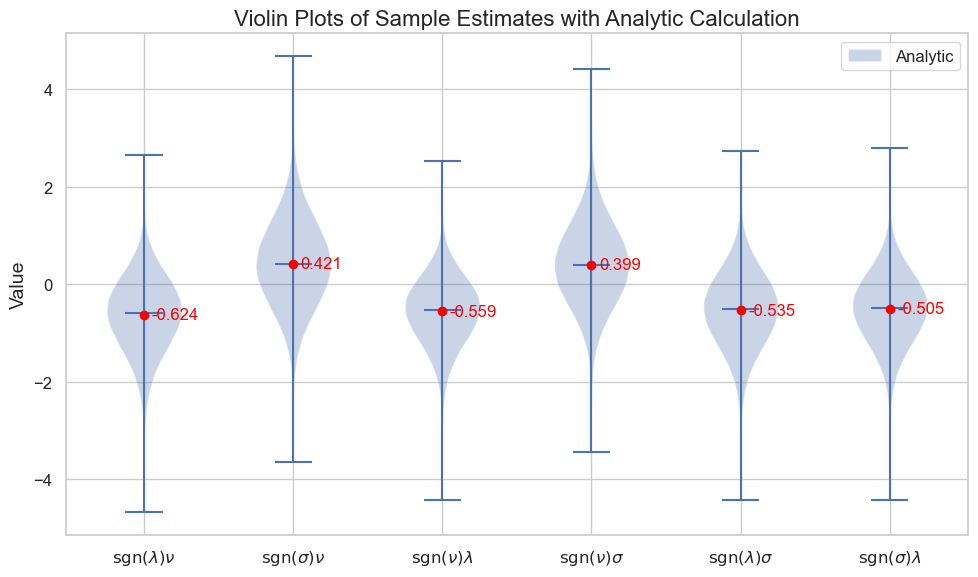

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))

# Data for violin plots
data = [
    sgn1_Nu_samples,
    sgn2_Nu_samples,
    sgnNu_1_samples,
    sgnNu_2_samples,
    sgn1_2_samples,
    sgn2_1_samples
]
labels = [
    r"$\mathrm{sgn}(\lambda)\nu$",
    r"$\mathrm{sgn}(\sigma)\nu$",
    r"$\mathrm{sgn}(\nu)\lambda$",
    r"$\mathrm{sgn}(\nu)\sigma$",
    r"$\mathrm{sgn}(\lambda)\sigma$",
    r"$\mathrm{sgn}(\sigma)\lambda$"
]
analytics = [
    float(sgn1_Nu),
    float(sgn2_Nu),
    float(sgnNu_1),
    float(sgnNu_2),
    float(sgn1_2),
    float(sgn2_1)
]

# Create violin plots
parts = ax.violinplot(data, showmeans=False, showmedians=True, showextrema=True)

# Set x-ticks and labels
ax.set_xticks([1, 2, 3, 4, 5, 6])
ax.set_xticklabels(labels)

# Annotate analytic values
for i, analytic in enumerate(analytics):
    ax.scatter(i+1, analytic, color='red', zorder=3, label='Analytic' if i == 0 else "")
    ax.text(i+1+0.05, analytic, f"{analytic:.3f}", color='red', va='center', fontsize=12)

ax.set_ylabel("Value")
ax.set_title("Violin Plots of Sample Estimates with Analytic Calculation")
ax.legend(["Analytic"], loc="upper right")
plt.tight_layout()
plt.show()

In [56]:
"""
now with next expectations
"""

P_1 = main_ode.HeaviLambdaNu(J_1, Q_1)
P_2 = main_ode.HeaviLambdaNu(J_2, Q_2)
P_12 = main_ode.Heavi12_heavi12Nu(J_1, J_2, Q_1, Q_2, Q_12, S)
P_12_collab = main_ode.Heavi12_negheavi12Nu(J_1, J_2, Q_1, Q_2, Q_12, S)

P_1_samples = np.heaviside(lambd * nu, 0)
P_2_samples = np.heaviside(sigma * nu, 0)
P_12_samples = np.heaviside(lambd * sigma, 0) * np.heaviside(lambd * nu, 0)
P_12_collab_samples = np.heaviside(lambd * sigma, 0) * np.heaviside(-lambd * nu, 0)

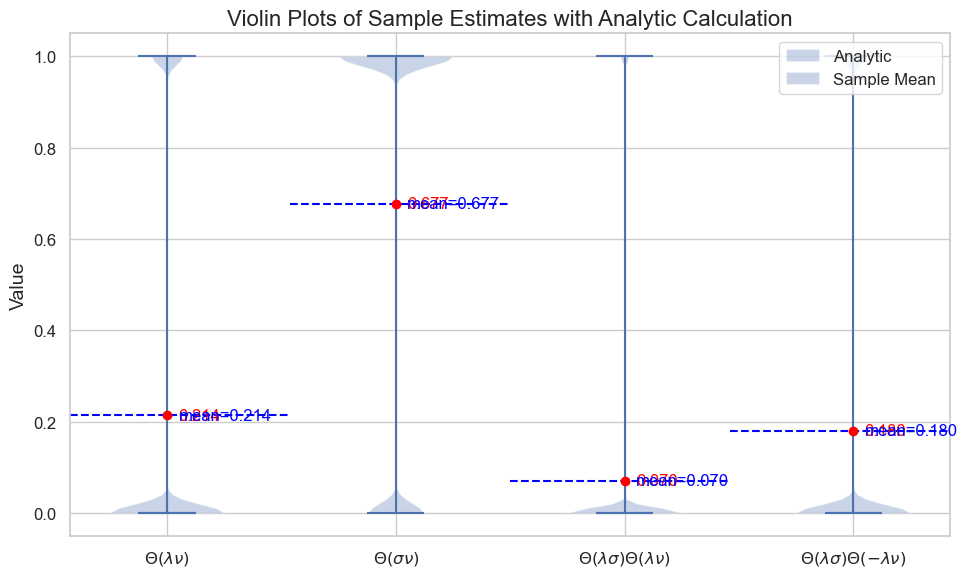

In [57]:
fig, ax = plt.subplots(figsize=(10, 6))

# Data for violin plots
data = [
    P_1_samples,
    P_2_samples,
    P_12_samples,
    P_12_collab_samples
]
labels = [
    r"$\Theta(\lambda\nu)$",
    r"$\Theta(\sigma\nu)$",
    r"$\Theta(\lambda\sigma)\Theta(\lambda\nu)$",
    r"$\Theta(\lambda\sigma)\Theta(-\lambda\nu)$"
]
analytics = [
    float(P_1),
    float(P_2),
    float(P_12),
    float(P_12_collab)
]

# Create violin plots
parts = ax.violinplot(data, showmeans=False, showmedians=True, showextrema=True)

# Set x-ticks and labels
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(labels)

# Annotate analytic values and sample means
for i, analytic in enumerate(analytics):
    ax.scatter(i+1, analytic, color='red', zorder=3, label='Analytic' if i == 0 else "")
    ax.text(i+1+0.05, analytic, f"{analytic:.3f}", color='red', va='center', fontsize=12)
    # Show mean of samples
    sample_mean = np.mean(data[i])
    ax.axhline(sample_mean, color='blue', linestyle='--', xmin=(i)/4, xmax=(i+1)/4, label='Sample Mean' if i == 0 else "")
    ax.text(i+1+0.05, sample_mean, f"mean={sample_mean:.3f}", color='blue', va='center', fontsize=12)

ax.set_ylabel("Value")
ax.set_title("Violin Plots of Sample Estimates with Analytic Calculation")
ax.legend(["Analytic", "Sample Mean"], loc="upper right")
plt.tight_layout()
plt.show()

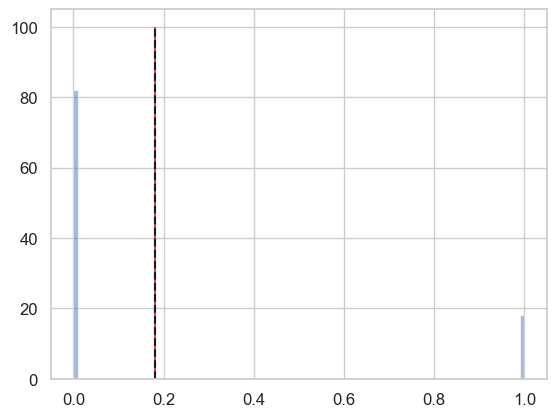

In [58]:
bins = np.logspace(-4, -1, 100)
plt.hist(P_12_collab_samples, bins=100, alpha=0.5, label='Q_1_emp - dQ_1', density=True, cumulative=False);

plt.vlines(P_12_collab, ymin=1e-5, ymax=1e2, colors='r', label='dQ_1')
plt.vlines(P_12_collab_samples.mean(), ymin=1e-5, ymax=1e2, colors='k', label='dQ_1', linestyles='dashed')
# plt.hist(dQ_1, bins=bins, alpha=0.5, label='Q_1_emp - dQ_1', density=True, cumulative=False);
#plt.xlim(1e-3,1e-2)
#plt.xscale('log')
#plt.yscale('log')

In [2]:
import numpy as np
epochs = 1000
savepoints = 200

save_epochs = np.unique(np.logspace(0, np.log10(epochs - 1), num=savepoints, dtype=int))
save_epochs = np.array(save_epochs)
deltas = np.diff(save_epochs, prepend=0)  # number of steps between savepoints
num_saves = save_epochs.shape[0]

print(len(deltas))
print(len(save_epochs))

130
130


In [3]:
print(save_epochs)
print(deltas)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  30  31  32  33  34  35  36  38
  39  41  42  43  45  47  48  50  52  54  56  58  60  62  64  66  69  71
  73  76  79  82  84  87  91  94  97 101 104 108 112 116 120 124 128 133
 138 143 148 153 158 164 170 176 182 188 195 202 209 216 224 232 240 249
 258 267 276 286 296 306 317 329 340 352 365 378 391 405 419 434 449 465
 481 499 516 534 553 573 593 614 636 658 681 706 730 756 783 811 839 869
 900 932 964 999]
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  2  1  1  1  1  1  1  2  1  2  1  1  2  2  1  2  2  2  2  2
  2  2  2  2  3  2  2  3  3  3  2  3  4  3  3  4  3  4  4  4  4  4  4  5
  5  5  5  5  5  6  6  6  6  6  7  7  7  7  8  8  8  9  9  9  9 10 10 10
 11 12 11 12 13 13 13 14 14 15 15 16 16 18 17 18 19 20 20 21 22 22 23 25
 24 26 27 28 28 30 31 32 32 35]


In [ ]:
Q_1, Q_2, Q_12, J_1, J_2, S = 0.8, 0.9, -0.6, -0.7, 0.5, 1

In [8]:
def sample_X_batch(D, n):
    X_s = random.multivariate_normal(mean=np.zeros(D), cov=np.eye(D), size=(n))
    return X_s

X_1_s = sample_X_batch(1000, 400000)
X_2_s = sample_X_batch(1000, 400000)

"""index = 1000

Covariance_t = population_covariance(D, 0.0, index)
Covariance_1 = population_covariance(D, 0.0, index)
Covariance_2 = population_covariance(D, 0.0, index)

teacher = perceptron(D, Covariance_t)
student_1 = perceptron(D, Covariance_1)
student_2 = perceptron(D, Covariance_2)"""

lambd_1 = np.einsum('D, n D -> n', student_1, X_1_s)
sigma_1 = np.einsum('D, n D -> n', student_2, X_1_s)
nu_1 = np.einsum('D, n D -> n', teacher, X_1_s)

lambd_2 = np.einsum('D, n D -> n', student_1, X_2_s)
sigma_2 = np.einsum('D, n D -> n', student_2, X_2_s)
nu_2 = np.einsum('D, n D -> n', teacher, X_2_s)

In [9]:
P_12_samples_1 = np.heaviside(lambd_1 * sigma_1, 0) * np.heaviside(lambd_1 * nu_1, 0)
P_12_collab_samples_1 = np.heaviside(lambd_1 * sigma_1, 0) * np.heaviside(-lambd_1 * nu_1, 0) * np.sign(lambd_1)

P_12_samples_2 = np.heaviside(lambd_2 * sigma_2, 0) * np.heaviside(lambd_2 * nu_2, 0)
P_12_collab_samples_2 = np.heaviside(lambd_2 * sigma_2, 0) * np.heaviside(-lambd_2 * nu_2, 0) * np.sign(lambd_2)

In [66]:
P_1_samples_1 = np.heaviside(lambd_1 * nu_1, 0)
P_1_samples_2 = np.heaviside(lambd_2 * nu_2, 0)

In [10]:
expectation_1 = np.einsum('n, n D -> n D', P_12_collab_samples_1, X_1_s)
expectation_2 = np.einsum('n, n D -> n D', P_12_collab_samples_2, X_2_s)

"""expectation_1 = np.einsum('n, n D -> n D', P_1_samples_1, X_1_s)
expectation_2 = np.einsum('n, n D -> n D', P_1_samples_2, X_2_s)"""

innerproduct = np.einsum('n D, n D -> n', expectation_1, expectation_2)

In [13]:
cross_term = Cross_term_cross_terms(J_1, J_2, Q_1, Q_2, Q_12, S)

In [21]:
print(J_1, J_2, Q_1, Q_2, Q_12, S)

-0.0004984823301849212 0.03619284745333354 1.0000000000000002 1.0000000000000002 -0.00963378813182797 0.9999999999999998


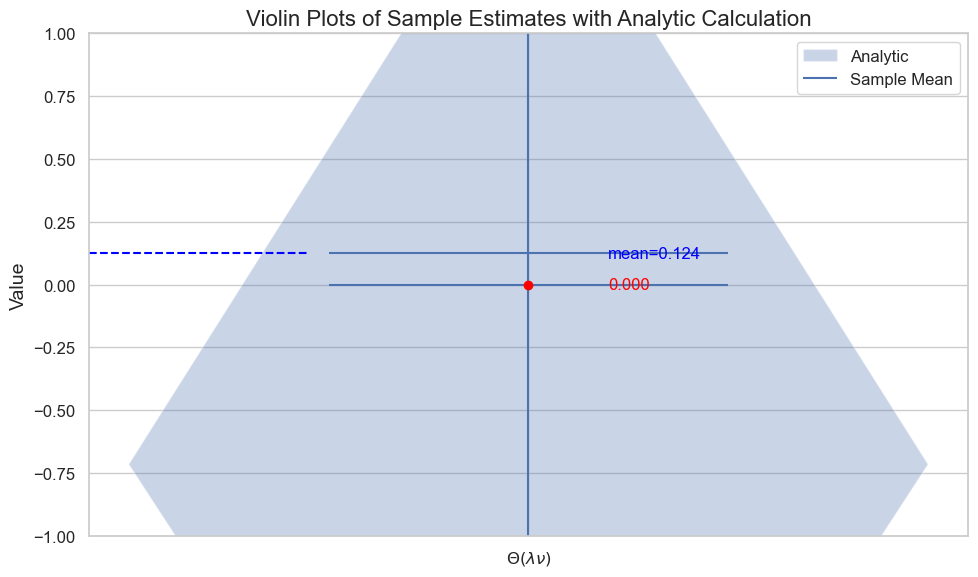

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))

# Data for violin plots
data = [
    innerproduct
]
labels = [
    r"$\Theta(\lambda\nu)$",
]
analytics = [
    cross_term,
]

# Create violin plots
parts = ax.violinplot(data, showmeans=True, showmedians=True, showextrema=True)

# Set x-ticks and labels
ax.set_xticks([1])
ax.set_xticklabels(labels)

# Annotate analytic values and sample means

for i, analytic in enumerate(analytics):
    ax.scatter(i+1, analytic, color='red', zorder=3, label='Analytic' if i == 0 else "")
    ax.text(i+1+0.05, analytic, f"{analytic:.3f}", color='red', va='center', fontsize=12)
    # Show mean of samples
    sample_mean = np.mean(data[i])
    ax.axhline(sample_mean, color='blue', linestyle='--', xmin=(i)/4, xmax=(i+1)/4, label='Sample Mean' if i == 0 else "")
    ax.text(i+1+0.05, sample_mean, f"mean={sample_mean:.3f}", color='blue', va='center', fontsize=12)

ax.set_ylabel("Value")
ax.set_title("Violin Plots of Sample Estimates with Analytic Calculation")
ax.legend(["Analytic", "Sample Mean"], loc="upper right")

ax.set_ylim(bottom=-1, top=1)
plt.tight_layout()
plt.show()



In [12]:
"""
we now test the distribution of the cross terms previously neglected in the Q updates
"""
def RhoXY_Z(Q_x, Q_y, Q_z, J_xz, J_yz, J_xy):
    return (J_xy * Q_z - J_xz * J_yz) / np.sqrt((Q_x * Q_z - J_xz**2) * (Q_y * Q_z - J_yz**2))

def Cross_term_cross_terms(J_1, J_2, Q_1, Q_2, Q_12, S):
    R_1 = RhoXY_Z(Q_2, S, Q_1, Q_12, J_1, J_2)
    R_2 = RhoXY_Z(Q_1, S, Q_2, Q_12, J_2, J_1)
    R_3 = RhoXY_Z(Q_1, Q_2, S, J_1, J_2, Q_12)

    return (8 / (np.pi**3) * 
    ((np.arcsin(R_1) + np.arcsin(R_2) + np.arcsin(R_3))**2 + 
                              2 * Q_12 / np.sqrt(Q_1 * Q_2) * np.arcsin(R_1) * np.arcsin(R_2) + 
                              2 * J_1 / np.sqrt(Q_1 * S) * np.arcsin(R_1) * np.arcsin(R_3) + 
                              2 * J_2 / np.sqrt(Q_2 * S) * np.arcsin(R_3) * np.arcsin(R_1)))